# Preparing the data for surface loads (case 1)

Load main libraries, set paths and adjust plotting theme (optional)

In [1]:
from pathlib import Path
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')
pv.global_theme.background = 'white'
pv.global_theme.color = "beige"
pv.global_theme.show_edges = True
pv.global_theme.window_size = [800, 400]

STATICS_DIR = Path("../../../../_static")
HEXBEAM_FILEPATH = STATICS_DIR / "hexbeam.vtk"

### Load the Mesh

In this examples, we are simply interested in manipulating the FEB file and not the mesh itself, therefore we will be used pre-defined mesh.
If you wish to create the mesh using python, we recommend using the pyvista or the gmsh and pygmsh libraries. 

Number of nodes: 1331
Number of cells: 1000


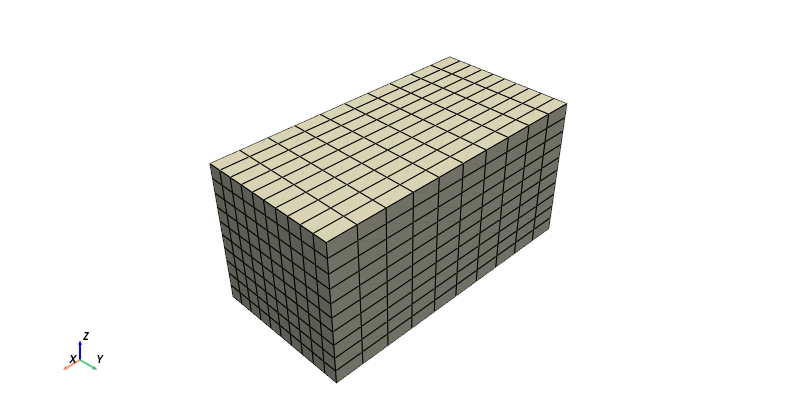

In [2]:
# Load the mesh
grid = pv.read(HEXBEAM_FILEPATH)
print(f"Number of nodes: {grid.n_points}")
print(f"Number of cells: {grid.n_cells}")
grid.plot(color="beige")

#### Find node ids for boundary conditions

In [3]:
# For the second block, find the "x-min" nodes
grid_nodes = grid.points
grid_xmin = np.min(grid_nodes[:, 0])
grid_boundary_ids = np.where(abs(grid_nodes[:, 0] - grid_xmin) <= 1e-6)[0]

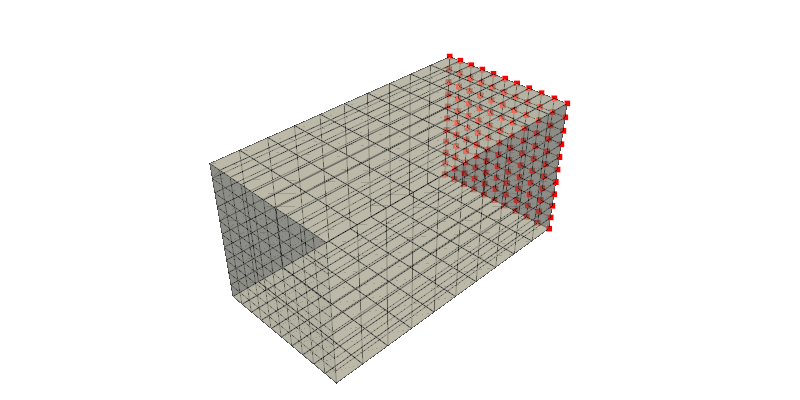

In [4]:
plotter = pv.Plotter()
plotter.add_mesh(grid, color="beige", opacity=0.5)
plotter.add_points(grid_nodes[grid_boundary_ids], color="red", point_size=6)
plotter.show()

### Create surface to apply surface load

In [5]:
# First, extract the surface of the first block
grid_surface = grid.extract_surface()
# Make sure it is a unsructured grid
grid_surface = grid_surface.cast_to_unstructured_grid()
# Compute cell centers
centers = grid_surface.cell_centers()
# find the "x-max" cell centers
center_xmax = np.max(centers.points[:, 0])
grid_surface_load_ids = np.where(abs(centers.points[:, 0] - center_xmax) <= 1e-6)[0]
selected_load_surface = grid_surface.copy().extract_cells(grid_surface_load_ids)
selected_load_surface = selected_load_surface.cast_to_unstructured_grid()

# we now need to map the node indices to the first original block
first_map = selected_load_surface["vtkOriginalPointIds"]  # from selected surface to extracted surface
second_map = grid_surface["vtkOriginalPointIds"]   # from extracted surface to original block mesh

load_surface_connectivity = selected_load_surface.cells_dict[pv.CellType.QUAD]

for i, cell in enumerate(load_surface_connectivity):
    cell = [first_map[j] for j in cell]
    load_surface_connectivity[i] = [second_map[j] for j in cell]

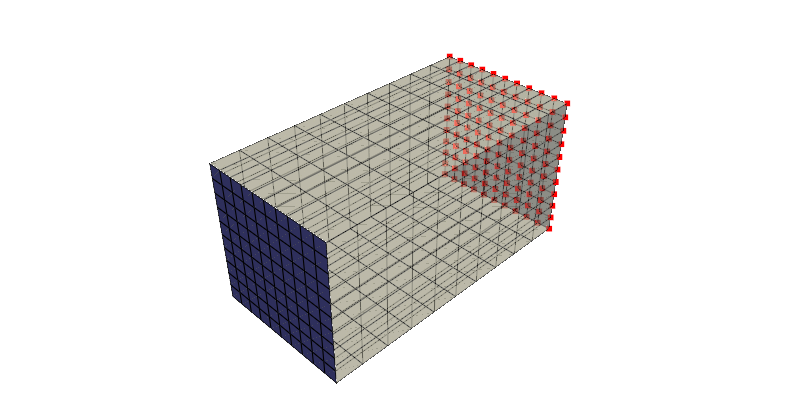

In [6]:
plotter = pv.Plotter()
plotter.add_mesh(grid, color="beige", opacity=0.5)
plotter.add_points(grid_nodes[grid_boundary_ids], color="red", point_size=6)
plotter.add_mesh(selected_load_surface, color="blue", point_size=6)
plotter.show()

### Saving as a multiblock

In [7]:
# Assign the discrete ids as field data
grid.field_data["boundary_ids"] = grid_boundary_ids
# Add the load surface connectivity as field data
selected_load_surface.field_data["load_surface_connectivity"] = load_surface_connectivity

In [8]:
mb = pv.MultiBlock(
    {
        "grid": grid,
        "selected_load_surface": selected_load_surface
    }
)

In [9]:
mb.save(STATICS_DIR / "hexbeam_multiblock_surface_load_case_1.vtm")